### Here doing Data cleaning and pre processing directly because I have done it clearly and seperately line by line in 
### DataCleaning and EDA Notebook

In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Function for preprocessing text data
def preprocess_text(df, text_column):
    # Lowercase the text
    df[text_column] = df[text_column].str.lower()
    
    # Remove special characters, punctuation, and symbols
    def remove_special_characters(text):
        pattern = r'[^a-zA-Z0-9\s]'  # Define regex pattern
        return re.sub(pattern, '', text)
    
    df[text_column] = df[text_column].apply(remove_special_characters)
    
    # Remove numbers
    def remove_numbers(text):
        pattern = r'\b\d+\b'  # Define regex pattern to match any standalone number
        return re.sub(pattern, '', text)
    
    df[text_column] = df[text_column].apply(remove_numbers)
    
    # Download stopwords list
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))
    
    # Remove stopwords
    def remove_stopwords(text):
        cleaned_text = ' '.join([word for word in text.split() if word not in stop_words])
        return cleaned_text
    
    df[text_column] = df[text_column].apply(remove_stopwords)
    
    # Tokenize text
    nltk.download('punkt')
    def tokenize_text(text):
        return word_tokenize(text)
    
    df['token'] = df[text_column].apply(tokenize_text)
    
    # Stemming
    stemmer = PorterStemmer()
    def stem_tokens(tokens):
        stemmed_tokens = [stemmer.stem(token) for token in tokens]
        return stemmed_tokens
    
    df['stemmed_token'] = df['token'].apply(stem_tokens)
    
    # Lemmatization
    nltk.download('wordnet')
    lemmatizer = WordNetLemmatizer()
    def lemmatize_tokens(tokens):
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
        return lemmatized_tokens
    
    df['lemmatized_token'] = df['stemmed_token'].apply(lemmatize_tokens)
    
    # Combine tokens into cleaned text
    df['cleaned_text'] = df['lemmatized_token'].apply(lambda tokens: ' '.join(tokens))
    
    return df

# Load data
data = pd.read_csv("hate.csv" , encoding='latin1')  

# Preprocess text data
data = preprocess_text(data, 'comment')


[nltk_data] Downloading package stopwords to C:\Users\Prayas
[nltk_data]     jain\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Prayas
[nltk_data]     jain\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Prayas
[nltk_data]     jain\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# LSTM

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from keras.callbacks import EarlyStopping

# Load the dataset

# Tokenize the text
max_features = 5000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(data['cleaned_text'].values)
X = tokenizer.texts_to_sequences(data['cleaned_text'].values)
X = pad_sequences(X)

# Split the dataset into features (X) and labels (y)
y = pd.get_dummies(data['label']).values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the LSTM model
embedding_dim = 128
model = Sequential()
model.add(Embedding(max_features, embedding_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model with validation data
batch_size = 64
epochs = 10
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1,
                    validation_split=0.1, callbacks=[early_stopping])

# Extract training metrics
training_accuracy = history.history['accuracy']
training_loss = history.history['loss']

# Extract validation metrics
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Print the final validation loss and accuracy
print("Final Validation Loss:", val_loss[-1])
print("Final Validation Accuracy:", val_accuracy[-1])

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy:", accuracy)





Epoch 1/10


463/463 [==============================] - 187s 396ms/step - loss: 0.6580 - accuracy: 0.6018 - val_loss: 0.5899 - val_accuracy: 0.6649
Epoch 2/10
463/463 [==============================] - 202s 435ms/step - loss: 0.5518 - accuracy: 0.7089 - val_loss: 0.5657 - val_accuracy: 0.7057
Epoch 3/10
463/463 [==============================] - 208s 450ms/step - loss: 0.5061 - accuracy: 0.7474 - val_loss: 0.5681 - val_accuracy: 0.7047
Epoch 4/10
463/463 [==============================] - 207s 447ms/step - loss: 0.4729 - accuracy: 0.7709 - val_loss: 0.5720 - val_accuracy: 0.7075
Epoch 5/10
463/463 [==============================] - 204s 441ms/step - loss: 0.4426 - accuracy: 0.7860 - val_loss: 0.5883 - val_accuracy: 0.6941
Final Validation Loss: 0.5883241891860962
Final Validation Accuracy: 0.694106936454773
Test Accuracy: 0.6774820685386658


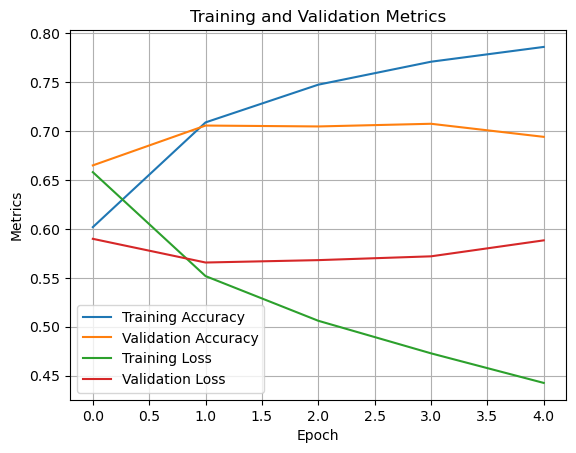

In [5]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Add labels and title
plt.title('Training and Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()
plt.grid(True)

# Show plot
plt.show()
